# Customize and Access NSIDC DAAC Data

This notebook will walk you through how to programmatically access data from the NASA National Snow and Ice Data Center Distributed Active Archive Center (NSIDC DAAC) using spatial and temporal filters, as well as how to request customization services including subsetting, reformatting, and reprojection. No Python experience is necessary; each code cell will prompt you with the information needed to configure your data request. The notebook will print the resulting API command that can be used in a command line, browser, or in Python as executed below.

### Import packages


In [2]:
import requests
import getpass
import socket 
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import re
import time
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth
%matplotlib inline

Input Earthdata Login credentials
An Earthdata Login account is required to access data from the NSIDC DAAC. If you do not already have an Earthdata Login account, visit http://urs.earthdata.nasa.gov to register.

In [3]:
# tonyzhang
uid = input('Earthdata Login user name: ') # Enter Earthdata Login user name

Earthdata Login user name:  tonyzhang


In [4]:

pswd = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password

Earthdata Login password:  ········


In [5]:
# uw email
email = input('Email address associated with Earthdata Login account: ') # Enter Earthdata login email 

Email address associated with Earthdata Login account:  zjd0721@uw.edu


### Select data set and determine version number

Data sets are selected by data set IDs (e.g. MOD10A1), whic are also referred to as a "short name". These short names are located at the top of each NSIDC data set landing page in gray above the full title.

In [6]:
# Input data set short name (e.g. ATL03) of interest here.
# ASO_50M_SWE
short_name = input('Input short name, e.g. ATL03, here: ')

Input short name, e.g. ATL03, here:  ASO_50M_SWE


In [7]:
# Get json response from CMR collection metadata

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

The most recent version of  ASO_50M_SWE  is  1


### Select time period of interest

In [21]:
#Input temporal range
# 2013-04-03
# 00:00:00
# 2019-07-17
# 00:00:00

start_date = input('Input start date in yyyy-MM-dd format: ')
start_time = input('Input start time in HH:mm:ss format: ')
end_date = input('Input end date in yyyy-MM-dd format: ')
end_time = input('Input end time in HH:mm:ss format: ')

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'

Input start date in yyyy-MM-dd format:  2013-04-03
Input start time in HH:mm:ss format:  00:00:00
Input end date in yyyy-MM-dd format:  2019-07-17
Input end time in HH:mm:ss format:  00:00:00


### Select area of interest

#### Select bounding box or shapefile entry

For all data sets, you can enter a bounding box to be applied to your file search. If you are interested in ICESat-2 data, you may also apply a spatial boundary based on a vector-based spatial data file.

In [22]:
# Enter spatial coordinates in decimal degrees, with west longitude and south latitude reported as negative degrees. Do not include spaces between coordinates.
# Example over the state of Colorado: -109,37,-102,41

bounding_box = input('Input spatial coordinates in the following order: lower left longitude,lower left latitude,upper right longitude,upper right latitude. Leave blank if you wish to provide a vector-based spatial file for ICESat-2 search and subsetting:')

Input spatial coordinates in the following order: lower left longitude,lower left latitude,upper right longitude,upper right latitude. Leave blank if you wish to provide a vector-based spatial file for ICESat-2 search and subsetting: 


#### Shapefile input for ICESat-2 search and subset

For ICESat-2 data only, you may also provide a geospatial file, including Esri Shapefile or KML/KMZ, to be applied to both your file search and subsetting request. Note that currently only files containing a single shape can be applied to the search. 

An example shapefile 'jacobshavn_bnd.shp' is included in this repository under the Shapefile_examples folder, demonstrated below. A shapefile of Pine Island glacier ('glims_polygons.shp') is also available, which was acquired from the NSIDC Global Land Ice Measurements from Space (GLIMS) database. Direct download access available from http://www.glims.org/maps/info.html?anlys_id=528486. If you would like to use a different geospatial file, you will need to adjust the filepath in the code block below.

Simplified polygon coordinates based on shapefile input: -119.58908883625021,38.18645781018878,-119.79955181625472,37.955164012608684,-119.42800694711637,37.8656690569239,-119.26039287108506,37.74143900630584,-119.19951408097548,37.8846229968368,-119.30914915468168,37.94606435409836,-119.31077632471995,38.04480313690451,-119.58908883625021,38.18645781018878


/tmp/ipykernel_109/3896187982.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gdf.buffer(50) #create buffer for plot bounds


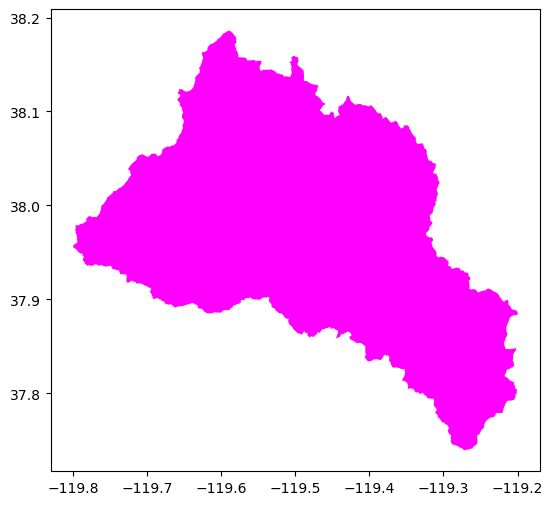

In [26]:
# aoi value used for filtering and subsetting logic below
if bounding_box == '': aoi = '2'
else: aoi = '1'

if aoi == '2':
    # Use geopandas to read in polygon file
    # Note: a KML or geojson, or almost any other vector-based spatial data format could be substituted here.

    shapefile_filepath = str(os.getcwd() + '/Tuolumne Basin Boundary/Tuolumne_cord.shp')

    # Go from geopandas GeoDataFrame object to an input that is readable by CMR
    gdf = gpd.read_file(shapefile_filepath)

    # CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
    
    # Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
    # Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
    
    poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)
    
    geojson = gpd.GeoSeries(poly).to_json() # Convert to geojson
    geojson = geojson.replace(' ', '') #remove spaces for API call

    #Format dictionary to polygon coordinate pairs for CMR polygon filtering
    polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

    print('Simplified polygon coordinates based on shapefile input:', polygon)
    
    buffer = gdf.buffer(50) #create buffer for plot bounds
    envelope = buffer.envelope  
    bounds = envelope.bounds
    
    # Load "Natural Earth” countries dataset, bundled with GeoPandas
    # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Overlay glacier outline
    f, ax = plt.subplots(1, figsize=(12, 6))
    # world.plot(ax=ax, facecolor='white', edgecolor='gray')
    gdf.plot(ax=ax, cmap='spring')
    # ax.set_ylim([bounds.miny[0], bounds.maxy[0]])
    # ax.set_xlim([bounds.minx[0], bounds.maxx[0]]);

### Determine how many granules exist over this time and area of interest.

In [27]:
# Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

if aoi == '1':
# bounding box input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    # If polygon file input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')


There are 98 granules of ASO_50M_SWE version 1 over my area and time of interest.


### Determine the average size of those granules as well as the total volume

In [28]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')


The average size of each granule is 6.39 MB and the total size of all 98 granules is 626.30 MB


Note that subsetting, reformatting, or reprojecting can alter the size of the granules if those services are applied to your request.

### Select the subsetting, reformatting, and reprojection services enabled for your data set of interest.

The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Let's discover whether or not our data set has these services available. If services are available, we will also determine the specific service options supported for this data set and select which of these services we want to request. 

### Query the service capability endpoint to gather service information needed below

In [29]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
if len(subagent) > 0 :

    # variable subsetting
    variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
    variables_raw = [variables[i]['value'] for i in range(len(variables))]
    variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
    variable_vals = [v.replace(':', '/') for v in variables_join]

    # reformatting
    formats = [Format.attrib for Format in root.iter('Format')]
    format_vals = [formats[i]['value'] for i in range(len(formats))]
    format_vals.remove('')

    # reprojection options
    projections = [Projection.attrib for Projection in root.iter('Projection')]

### Select subsetting, reformatting, and reprojection service options, if available.

In [30]:
#print service information depending on service availability and select service options
    
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    bbox = ''
    time_var = ''
    reformat = ''
    projection = ''
    projection_parameters = ''
    coverage = ''
    Boundingshape = ''
else:
    agent = ''
    subdict = subagent[0]
    if subdict['spatialSubsetting'] == 'true' and aoi == '1':
        Boundingshape = ''
        ss = input('Subsetting by bounding box, based on the area of interest inputted above, is available. Would you like to request this service? (y/n)')
        if ss == 'y': bbox = bounding_box
        else: bbox = '' 
    if subdict['spatialSubsettingShapefile'] == 'true' and aoi == '2':
        bbox = ''
        ps = input('Subsetting by geospatial file (Esri Shapefile, KML, etc.) is available. Would you like to request this service? (y/n)')
        if ps == 'y': Boundingshape = geojson
        else: Boundingshape = '' 
    if subdict['temporalSubsetting'] == 'true':
        ts = input('Subsetting by time, based on the temporal range inputted above, is available. Would you like to request this service? (y/n)')
        if ts == 'y': time_var = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time 
        else: time_var = ''
    else: time_var = ''
    if len(format_vals) > 0 :
        print('These reformatting options are available:', format_vals)
        reformat = input('If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.')
        if reformat == 'n': reformat = '' # Catch user input of 'n' instead of leaving blank
    else: 
        reformat = ''
        projection = ''
        projection_parameters = ''
    if len(projections) > 0:
        valid_proj = [] # select reprojection options based on reformatting selection
        for i in range(len(projections)):
            if 'excludeFormat' in projections[i]:
                exclformats_str = projections[i]['excludeFormat'] 
                exclformats_list = exclformats_str.split(',')
            if ('excludeFormat' not in projections[i] or reformat not in exclformats_list) and projections[i]['value'] != 'NO_CHANGE': valid_proj.append(projections[i]['value'])
        if len(valid_proj) > 0:
            print('These reprojection options are available with your requested format:', valid_proj)
            projection = input('If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes), otherwise leave blank.')
            # Enter required parameters for UTM North and South
            if projection == 'UTM NORTHERN HEMISPHERE' or projection == 'UTM SOUTHERN HEMISPHERE': 
                NZone = input('Please enter a UTM zone (1 to 60 for Northern Hemisphere; -60 to -1 for Southern Hemisphere):')
                projection_parameters = str('NZone:' + NZone)
            else: projection_parameters = ''
        else: 
            print('No reprojection options are supported with your requested format')
            projection = ''
            projection_parameters = ''
    else:
        print('No reprojection options are supported with your requested format')
        projection = ''
        projection_parameters = ''

No services exist for ASO_50M_SWE version 1


Because variable subsetting can include a long list of variables to choose from, we will decide on variable subsetting separately from the service options above.

In [31]:
# Select variable subsetting

if len(subagent) > 0 :
    if len(variable_vals) > 0:
        v = input('Variable subsetting is available. Would you like to subset a selection of variables? (y/n)')
        if v == 'y':
            print('The', short_name, 'variables to select from include:')
            print(*variable_vals, sep = "\n") 
            coverage = input('If you would like to subset by variable, copy and paste the variables you would like separated by comma (be sure to remove spaces and retain all forward slashes: ')
        else: coverage = ''

#no services selected
if reformat == '' and projection == '' and projection_parameters == '' and coverage == '' and time_var == '' and bbox == '' and Boundingshape == '':
    agent = 'NO'

### Select data access configurations

The data request can be accessed asynchronously or synchronously. The asynchronous option will allow concurrent requests to be queued and processed without the need for a continuous connection. Those requested orders will be delivered to the specified email address, or they can be accessed programmatically as shown below. Synchronous requests will automatically download the data as soon as processing is complete. The granule limits differ between these two options:

Maximum granules per synchronous request = 100 

Maximum granules per asynchronous request = 2000 

We will set the access configuration depending on the number of granules requested. For requests over 2000 granules, we will produce multiple API endpoints for each 2000-granule order. Please note that synchronous requests may take a long time to complete depending on request parameters, so the number of granules may need to be adjusted if you are experiencing performance issues. The `page_size` parameter can be used to adjust this number. 

In [32]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 1 total order(s) processed for our ASO_50M_SWE request.


### Create the API endpoint 

Programmatic API requests are formatted as HTTPS URLs that contain key-value-pairs specifying the service operations that we specified above. The following command can be executed via command line, a web browser, or in Python below. 

In [33]:
if aoi == '1':
# bounding box search and subset:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'bounding_box': bounding_box, 
                  'bbox': bbox, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }
else:
    # If polygon file input:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'polygon': polygon,
                  'Boundingshape': Boundingshape, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print(*endpoint_list, sep = "\n") 

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ASO_50M_SWE&version=1&temporal=2013-04-03T00:00:00Z,2019-07-17T00:00:00Z&polygon=-119.58908883625021,38.18645781018878,-119.79955181625472,37.955164012608684,-119.42800694711637,37.8656690569239,-119.26039287108506,37.74143900630584,-119.19951408097548,37.8846229968368,-119.30914915468168,37.94606435409836,-119.31077632471995,38.04480313690451,-119.58908883625021,38.18645781018878&page_size=100&request_mode=stream&agent=NO&email=zjd0721@uw.edu&page_num=1


### Request data

We will now download data using the Python requests library. The data will be downloaded directly to this notebook directory in a new Outputs folder. The progress of each order will be reported.

In [34]:
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/ASO_50m_lidar_data')
if not os.path.exists(path):
    os.mkdir(path)

# Different access methods depending on request mode:

if request_mode=='async':
    # Request data service for each page number, and unzip outputs
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)

    # For all requests other than spatial file upload, use get function
        param_dict['page_num'] = page_val
        request = session.get(base_url, params=param_dict)

        print('Request HTTP response: ', request.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        print('Order request response XML content: ', request.content)

    #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)

    #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)

    #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)

    #Continue loop while request is still processing
        while status == 'pending' or status == 'processing': 
            print('Status is not complete. Trying again.')
            time.sleep(10)
            loop_response = session.get(statusURL)

    # Raise bad request: Loop will stop for bad response code.
            loop_response.raise_for_status()
            loop_root = ET.fromstring(loop_response.content)

    #find status
            statuslist = []
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue

    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
        if status == 'complete_with_errors' or status == 'failed':
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
        if status == 'complete' or status == 'complete_with_errors':
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            # Raise bad request: Loop will stop for bad response code.
            zip_response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request', page_val, 'is complete.')
        else: print('Request failed.')
            
else:
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
        print('Requesting...')
        request = session.get(base_url, params=param_dict)
        print('HTTP response from order response URL: ', request.status_code)
        request.raise_for_status()
        d = request.headers['content-disposition']
        fname = re.findall('filename=(.+)', d)
        dirname = os.path.join(path,fname[0].strip('\"'))
        print('Downloading...')
        open(dirname, 'wb').write(request.content)
        print('Data request', page_val, 'is complete.')
    
    # Unzip outputs
    for z in os.listdir(path): 
        if z.endswith('.zip'): 
            zip_name = path + "/" + z 
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(path) 
            zip_ref.close() 
            os.remove(zip_name) 


Order:  1
Requesting...
HTTP response from order response URL:  200
Downloading...
Data request 1 is complete.


### Finally, we will clean up the Output folder by removing individual order folders:

In [35]:
# Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))    

### To review, we have explored data availability and volume over a region and time of interest, discovered and selected data customization options, constructed an API endpoint for our request, and downloaded data directly to our local machine. You are welcome to request different data sets, areas of interest, and/or customization services by re-running the notebook or starting again at the 'Select a data set of interest' step above. 